In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import numpy as np
from PIL import Image
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
from itertools import chain
import tensorflow as tf
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
from transformers import XLNetTokenizer, TFXLNetModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve,average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, log_loss
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Read Data

In [2]:
df=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
wordcloud_mask=np.array(Image.open("/kaggle/input/wodcloud-twiter-pic/twitter.png"))

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
df.shape

(7613, 5)

In [7]:
df.drop(["id","keyword","location"], axis=1,inplace=True)

In [8]:
df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


### You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

In [9]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

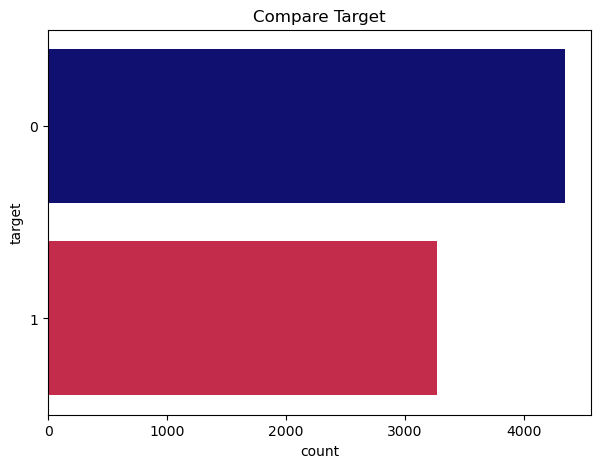

In [10]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, y="target",palette=["navy","crimson"])
plt.title("Compare Target")
plt.show()

# Count Character

In [11]:
df["character_count"]=df["text"].str.len()

# Count Word

In [12]:
df['word_count'] = df['text'].str.split().str.len()


# Count Sentence

In [13]:
df['sentence_count'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))


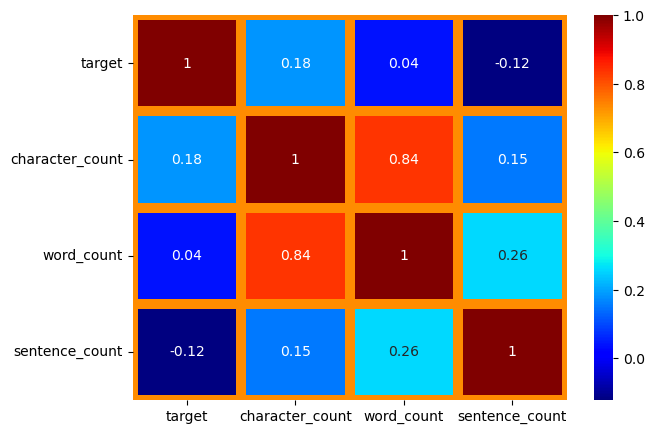

In [14]:
cor=df[["target","character_count","word_count","sentence_count"]].corr()
plt.figure(figsize=(7,5))
sns.heatmap(cor,annot=True,cmap="jet",linewidths=7, linecolor='darkorange')
plt.show()

# Data Length

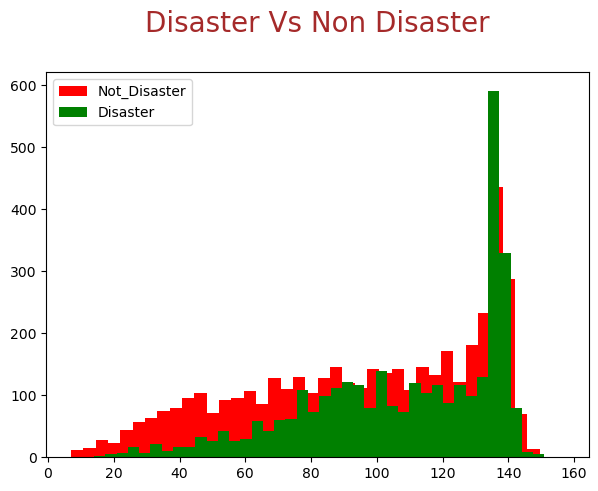

In [15]:
notdisaster_len=df[df["target"]==0]["text"].str.len()
disaster_len=df[df["target"]==1]["text"].str.len()
plt.figure(figsize=(7,5))
plt.hist(notdisaster_len, bins=40,label='Not_Disaster',color="red")
plt.hist(disaster_len , bins=40, label='Disaster',color="green")
plt.title("Disaster Vs Non Disaster\n",fontsize=20,color="brown")
plt.legend()
plt.show()

# ALL Data Wordcloud

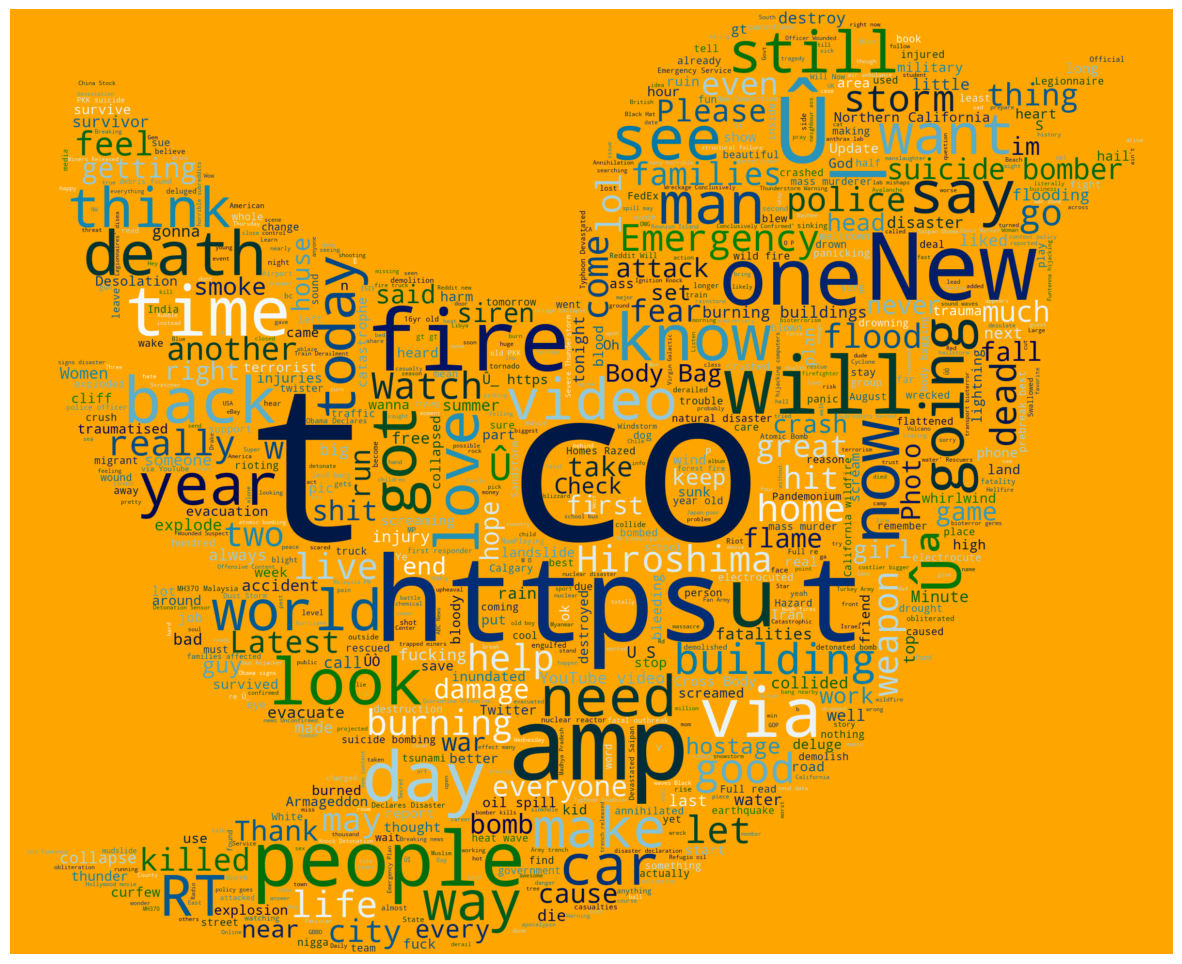

In [16]:
plt.figure(figsize=(15,15))
all_text=" ".join(df['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='orange', max_words=800,colormap="ocean",mask=wordcloud_mask).generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Disaster Data Wordcloud

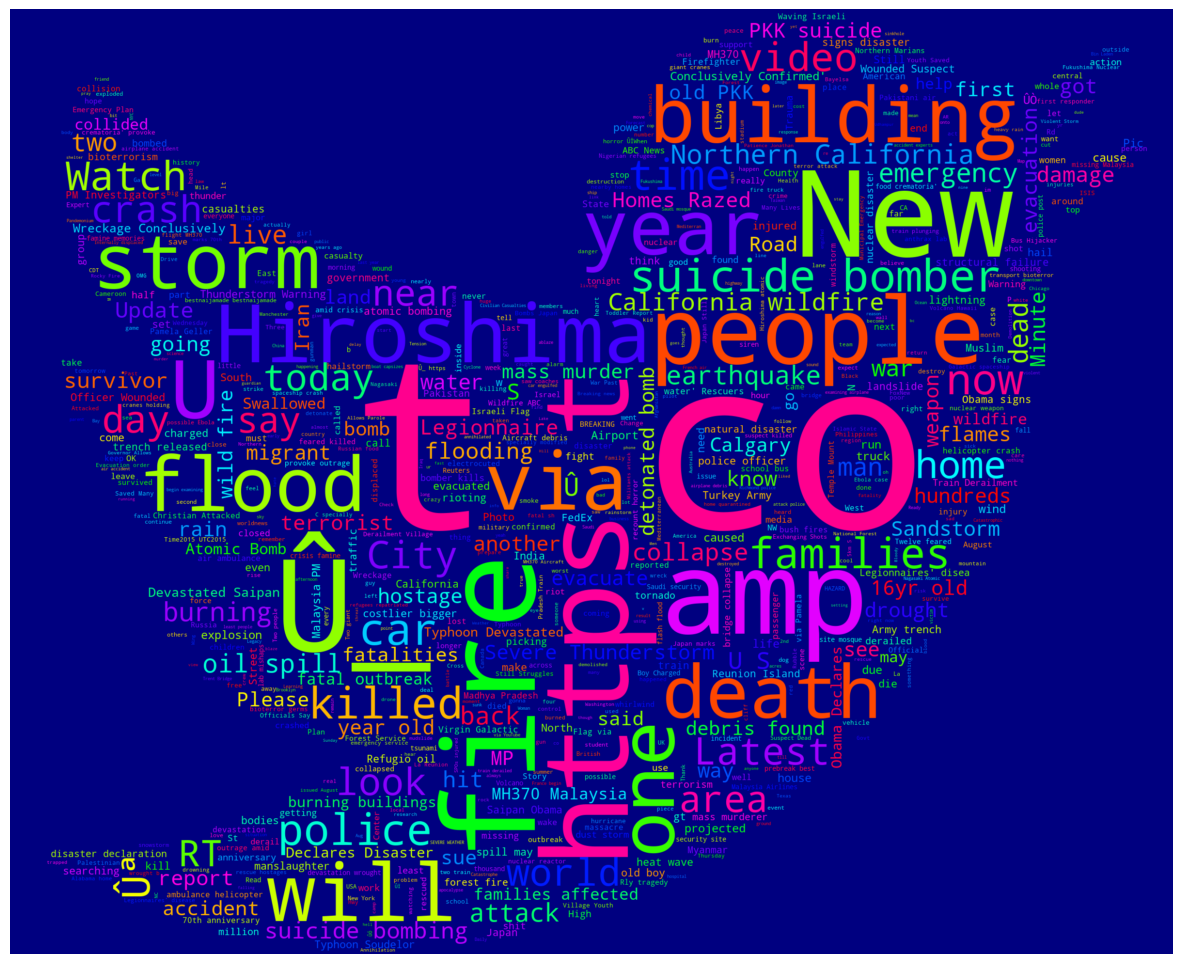

In [17]:
plt.figure(figsize=(15,15))
disaster_wordcloud=df[df["target"]==1]
disaster_text=" ".join(disaster_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='navy', max_words=800,colormap="hsv",mask=wordcloud_mask).generate(disaster_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Non Disaster Wordcloud

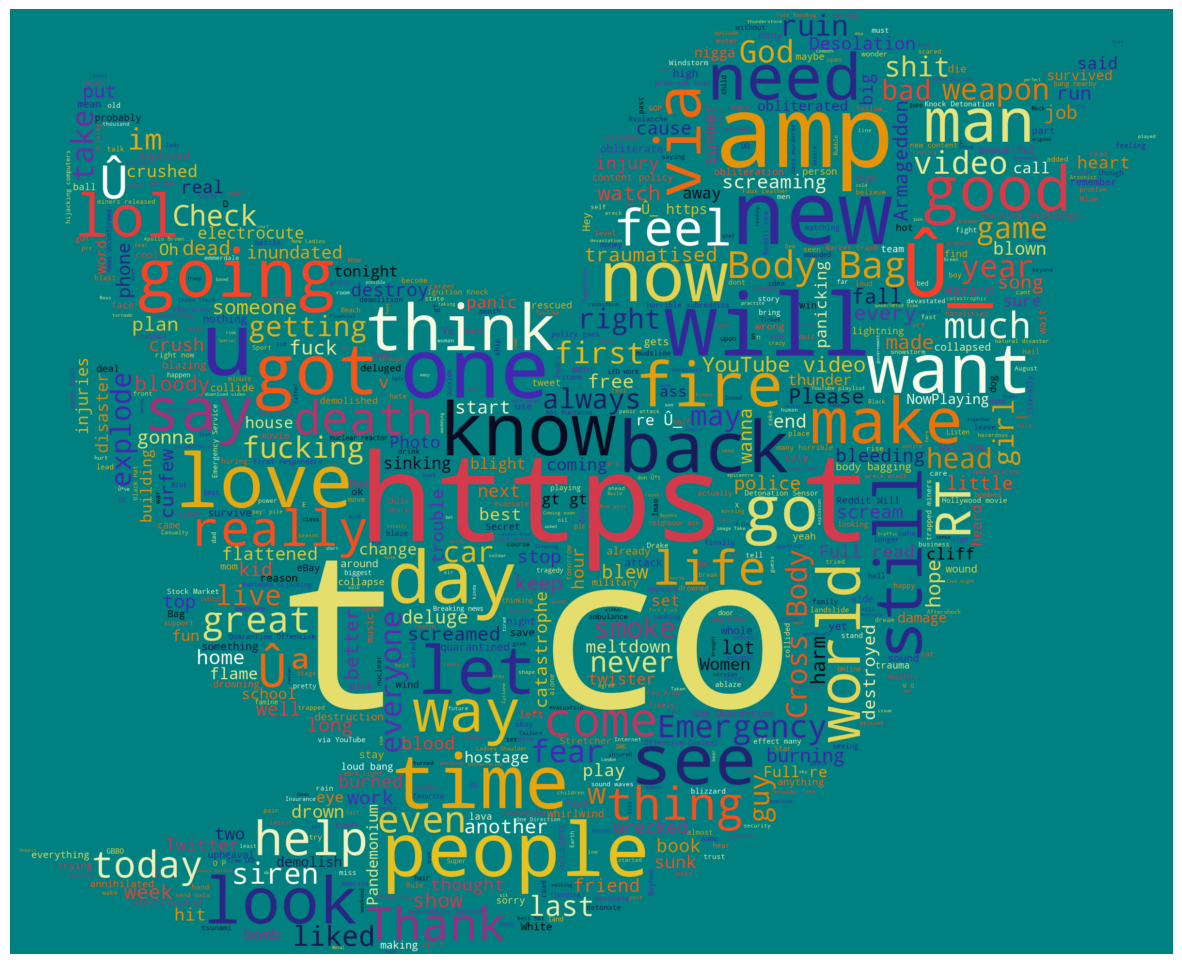

In [18]:
plt.figure(figsize=(15,15))
nondisaster_wordcloud=df[df["target"]==0]
nondisaster_text=" ".join(nondisaster_wordcloud['text'].values.tolist())
wordcloud = WordCloud(width=800, height=800,stopwords=STOPWORDS, background_color='teal', max_words=800,colormap="CMRmap",mask=wordcloud_mask).generate(nondisaster_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 30 Most common Words From All Text

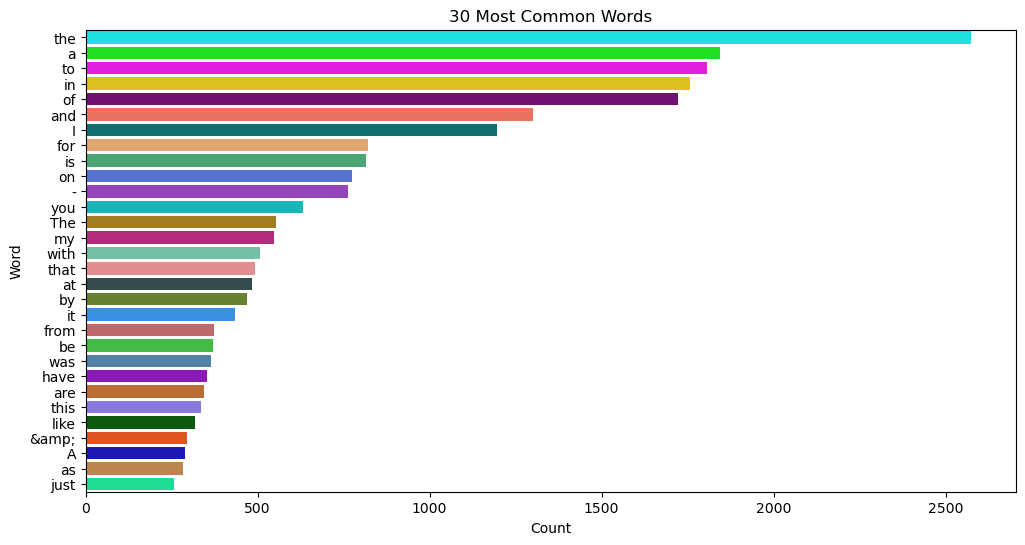

In [19]:
data_set =df["text"].str.split()
all_words = list(chain.from_iterable(data_set))
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

colors = ["cyan", "lime", "magenta", "gold", "purple", "tomato", "teal", "sandybrown", "mediumseagreen",
          "royalblue", "darkorchid", "darkturquoise", "darkgoldenrod", "mediumvioletred", "mediumaquamarine",
          "lightcoral", "darkslategray", "olivedrab", "dodgerblue", "indianred", "limegreen", "steelblue",
          "darkviolet", "chocolate", "mediumslateblue", "darkgreen", "orangered", "mediumblue", "peru", "mediumspringgreen"]

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=df_common_words, palette=colors)
plt.title('30 Most Common Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()


# Most Common Words From Non Disaster Text

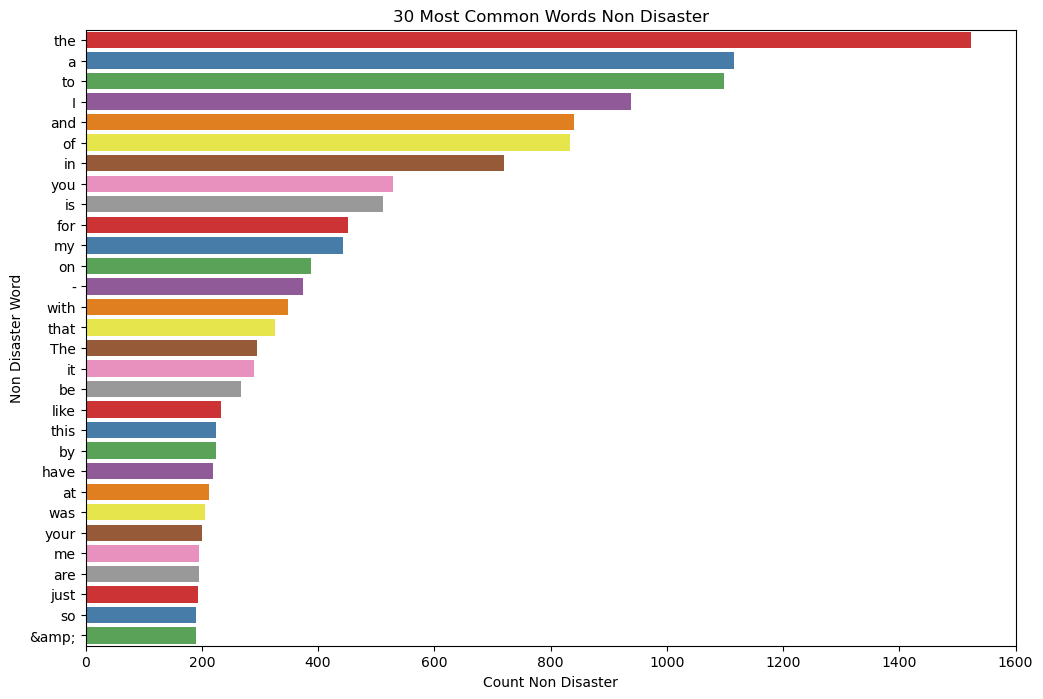

In [20]:
no_disaster_text = df[df["target"] == 0]
data_set = no_disaster_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=df_common_words,palette="Set1")
plt.title('30 Most Common Words Non Disaster')
plt.xlabel('Count Non Disaster')
plt.ylabel('Non Disaster Word')
plt.show()



# 30 Most Common Words From Disaster Text

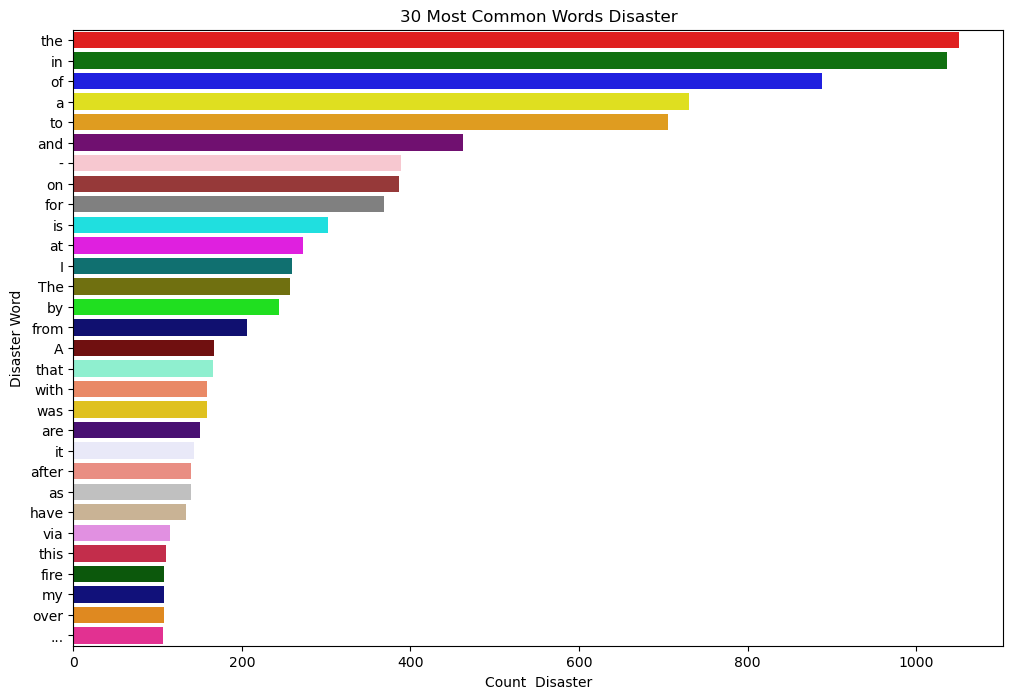

In [21]:
disaster_text = df[df["target"] == 1]
data_set = disaster_text["text"].str.split()
all_words = [word for sublist in data_set for word in sublist]
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 8))
colors = ["red", "green", "blue", "yellow", "orange", "purple", "pink", "brown", "gray",
          "cyan", "magenta", "teal", "olive", "lime", "navy", "maroon", "aquamarine",
          "coral", "gold", "indigo", "lavender", "salmon", "silver", "tan", "violet",
          "crimson", "darkgreen", "darkblue", "darkorange", "deeppink"]
sns.barplot(x='Count', y='Word', data=df_common_words,palette=colors)
plt.title('30 Most Common Words Disaster')
plt.xlabel('Count  Disaster')
plt.ylabel('Disaster Word')
plt.show()


# Character Count

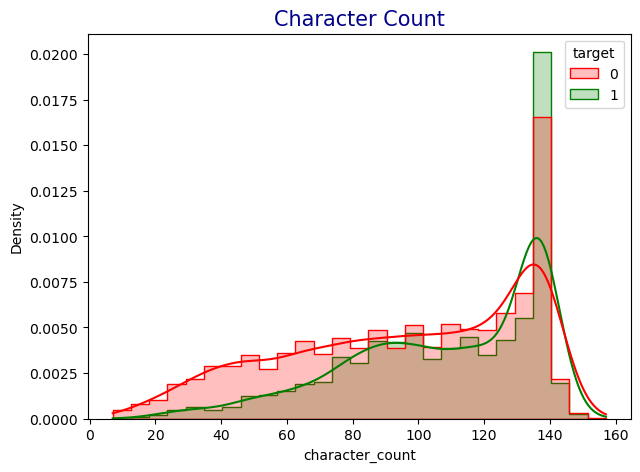

In [22]:
color=["red","green"]
plt.figure(figsize=(7,5))

sns.histplot(data=df,x="character_count",palette=color,kde=True,hue="target",element="step",stat="density")
plt.title("Character Count",fontsize=15,color="darkblue")
plt.show()

# Word Count

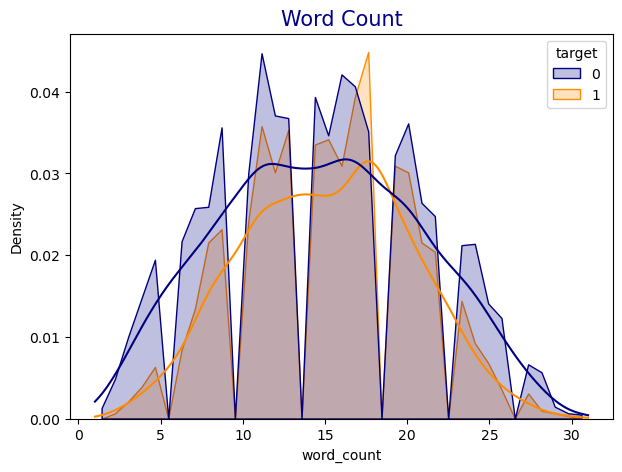

In [23]:
color=["navy","darkorange"]
plt.figure(figsize=(7,5))

sns.histplot(data=df,x="word_count",palette=color,kde=True,hue="target",element="poly",stat="density")
plt.title("Word Count",fontsize=15,color="darkblue")
plt.show()

# Sentence Count

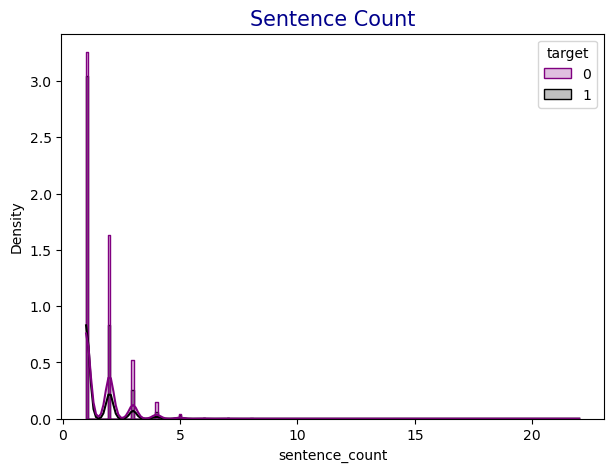

In [24]:
color=["purple","black"]
plt.figure(figsize=(7,5))
sns.histplot(data=df,x="sentence_count",palette=color,kde=True,hue="target",element="step",stat="density")
plt.title("Sentence Count",fontsize=15,color="darkblue")
plt.show()

In [25]:
df.drop(["character_count","word_count","sentence_count"],axis=1,inplace=True)

# Average Sentence Length

In [26]:
avg_len=df["text"].apply(len)
avg_len=avg_len.mean()
print(f"Average Text Length is : {avg_len:.2f}")

Average Text Length is : 101.04


# Maximum Length

In [27]:
max_len=100

In [28]:

text_data=df["text"]
label_data=df["target"]
label_data=np.array(label_data)

# XLNET Tokenizer,Model

In [29]:
xlnet_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = TFXLNetModel.from_pretrained('xlnet-base-cased')



/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel w

# Encode Data

In [30]:
def xlnet_encode(final_text_data, max_len):
    input_ids = []
    attention_masks = []
    
    for i in range(len(final_text_data)):
        encode_data = xlnet_tokenizer.encode_plus(final_text_data[i], add_special_tokens=True, max_length=max_len, pad_to_max_length=True, return_attention_mask=True)
        input_ids.append(encode_data['input_ids'])
        attention_masks.append(encode_data["attention_mask"])
    
    return np.array(input_ids), np.array(attention_masks)


In [31]:
text_input_ids,text_attention_masks = xlnet_encode(text_data,max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [32]:
print('Text Input Ids Shape {} \nText Input Attention Mask Shape {} \nLabel Data shape {}'.format(text_input_ids.shape,text_attention_masks.shape,label_data.shape))

Text Input Ids Shape (7613, 100) 
Text Input Attention Mask Shape (7613, 100) 
Label Data shape (7613,)


In [33]:
X_train,X_test,Y_train,Y_test,train_mask,test_mask=train_test_split(text_input_ids,label_data,text_attention_masks,test_size=0.2,random_state=42,shuffle=True)

In [34]:
print('Train input shape {}\nTest input shape {}\nTrain label shape {}\nTest label shape {}\nTrain attention mask shape {}\nTest attention mask shape {}'.format(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape,train_mask.shape,test_mask.shape))

Train input shape (6090, 100)
Test input shape (1523, 100)
Train label shape (6090,)
Test label shape (1523,)
Train attention mask shape (6090, 100)
Test attention mask shape (1523, 100)


# Create XLNET Model

In [35]:
def Create_XLNet_Model():
    input_ids = tf.keras.Input(shape=(max_len,), dtype="int32")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype="int32")

    output = xlnet_model(input_ids=input_ids, attention_mask=attention_masks)[0]
    
    output = tf.keras.layers.GlobalMaxPooling1D()(output)
   
    dense_1 = tf.keras.layers.Dense(256, activation="tanh")(output)  
    dense_2 = tf.keras.layers.Dense(128, activation="tanh")(dense_1)  
  
    dense_3 = tf.keras.layers.Dense(64, activation="tanh")(dense_2)  
  
    dropout = tf.keras.layers.Dropout(0.2)(dense_3)
    output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output_layer)
    return model





In [36]:
model = Create_XLNet_Model()

learning_rate = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

loss = "binary_crossentropy"
metric = "accuracy"

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tfxl_net_model (TFXLNetModel)  TFXLNetModelOutput(  116718336   ['input_1[0][0]',                
                                last_hidden_state=(               'input_2[0][0]']                
                                None, 100, 768),                                                  
                                 mems=((100, None,                                            

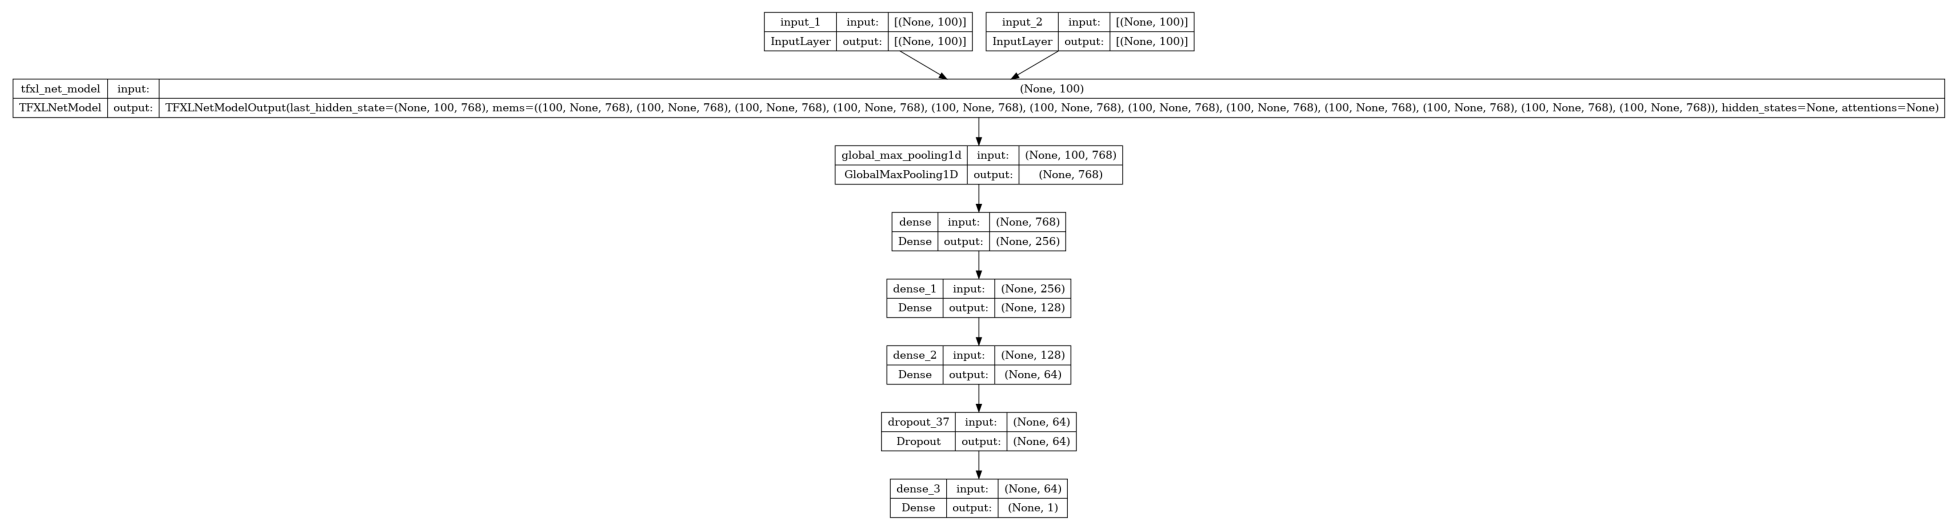

In [37]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)
plt.figure(figsize=(25, 15))
img = plt.imread('model_architecture.png')
plt.imshow(img)
plt.axis('off')
plt.show()


In [38]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [39]:
history = model.fit(x=[X_train, train_mask],y=Y_train,validation_data=([X_test, test_mask], Y_test),
                    epochs=30,batch_size=32,callbacks=[early_stopping])

Epoch 1/30
191/191 [==============================] - 161s 588ms/step - loss: 0.5267 - accuracy: 0.7471 - val_loss: 0.4365 - val_accuracy: 0.8188
Epoch 2/30
191/191 [==============================] - 102s 535ms/step - loss: 0.4390 - accuracy: 0.8151 - val_loss: 0.4054 - val_accuracy: 0.8365
Epoch 3/30
191/191 [==============================] - 101s 527ms/step - loss: 0.3810 - accuracy: 0.8458 - val_loss: 0.3920 - val_accuracy: 0.8496
Epoch 4/30
191/191 [==============================] - 100s 526ms/step - loss: 0.3445 - accuracy: 0.8624 - val_loss: 0.4406 - val_accuracy: 0.8148
Epoch 5/30
191/191 [==============================] - 100s 524ms/step - loss: 0.3179 - accuracy: 0.8821 - val_loss: 0.4034 - val_accuracy: 0.8280
Epoch 6/30
191/191 [==============================] - 100s 524ms/step - loss: 0.2838 - accuracy: 0.8944 - val_loss: 0.4769 - val_accuracy: 0.7938
Epoch 7/30
191/191 [==============================] - 100s 523ms/step - loss: 0.2561 - accuracy: 0.9136 - val_loss: 0.4957 -

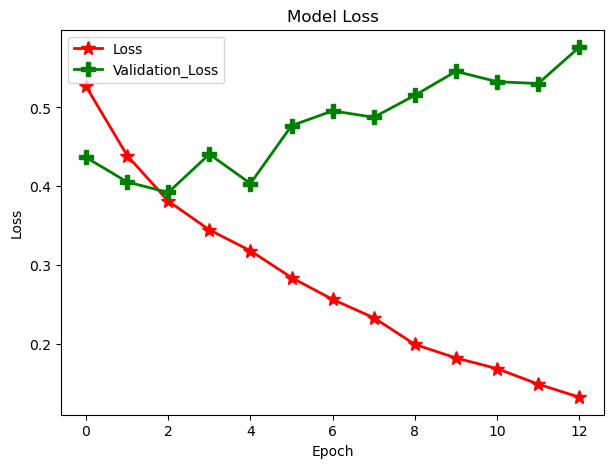

In [40]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'],lw=2,marker="*",markersize=10,color="red",label="Loss")
plt.plot(history.history['val_loss'],lw=2,marker="P",markersize=10,color="green",label="Validation_Loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.show()

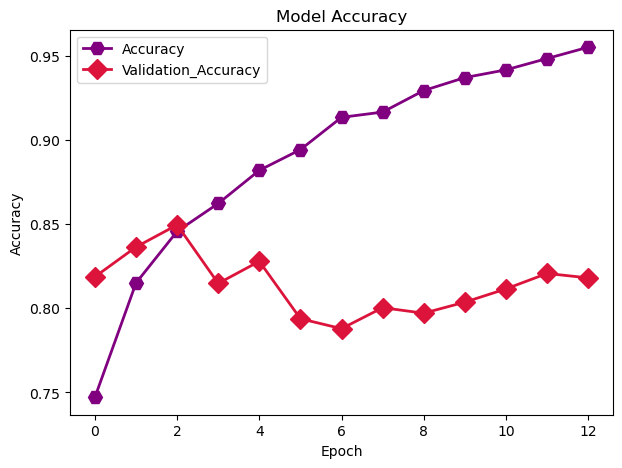

In [41]:
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'],lw=2,marker="H",markersize=10,color="purple",label="Accuracy")
plt.plot(history.history['val_accuracy'],lw=2,marker="D",markersize=10,color="crimson",label="Validation_Accuracy")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.show()

# Model predict

In [42]:
pred = model.predict([X_test, test_mask])
final_pred = np.where(pred >= 0.5, 1, 0)  


48/48 [==============================] - 11s 159ms/step


# ROC Curve

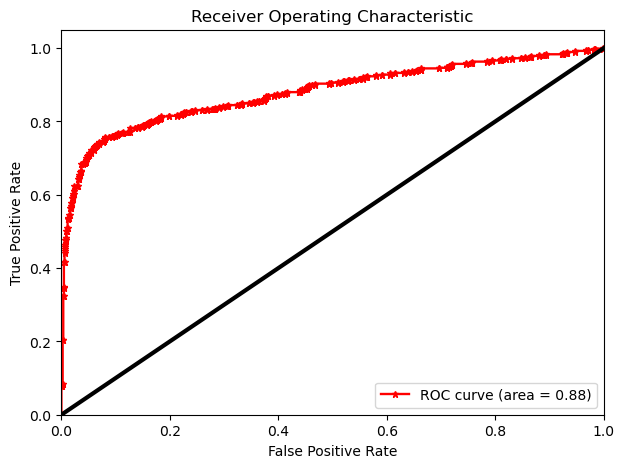

In [43]:
fpr, tpr, thresholds = roc_curve(Y_test,pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc,color="red",lw=1.7,marker="*",markersize=5)
plt.plot([0, 1], [0, 1],color="black",lw=3) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve

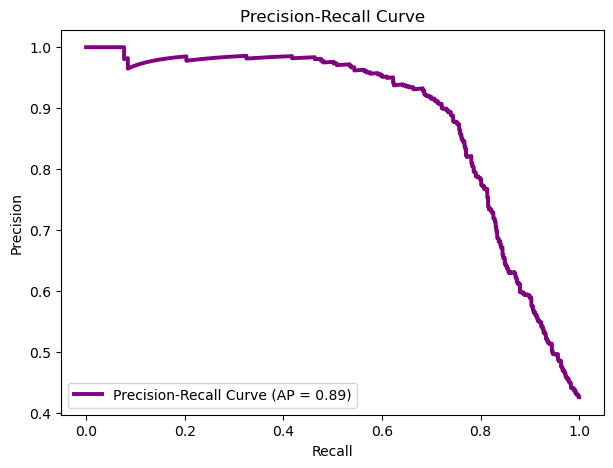

In [44]:
precision, recall, thresholds = precision_recall_curve(Y_test,pred)
ap_score = average_precision_score(Y_test,pred)
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label='Precision-Recall Curve (AP = %0.2f)' % ap_score,color="purple",lw=2.8)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

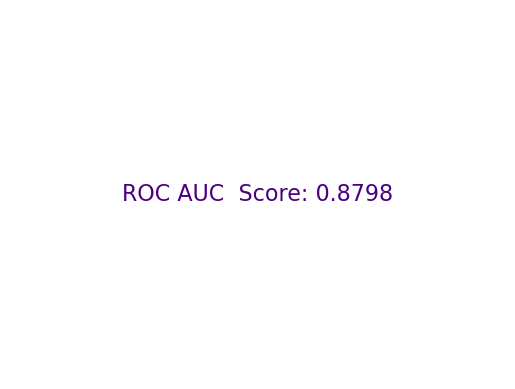

In [45]:
roc_auc = roc_auc_score(Y_test, pred)
plt.plot([])
plt.text(0,0, f'ROC AUC  Score: {roc_auc:.4f}', fontsize=16, ha='center', va='center',color="indigo")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

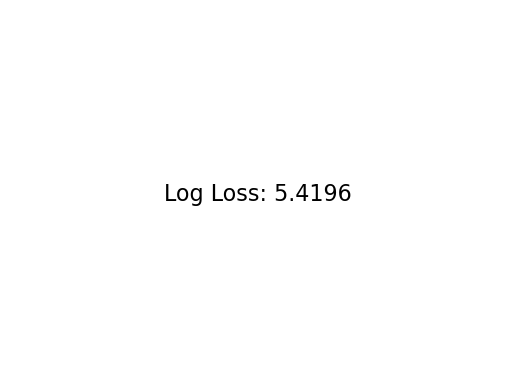

In [46]:
logarithm_loss=log_loss(Y_test,final_pred)
plt.plot([])
plt.text(0,0, f'Log Loss: {logarithm_loss:.4f}', fontsize=16, ha='center', va='center',color="black")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

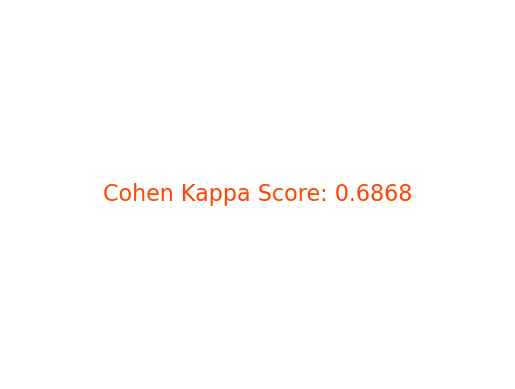

In [47]:
kappa = cohen_kappa_score(Y_test,final_pred)
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score: {kappa:.4f}', fontsize=16, ha='center', va='center',color="orangered")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

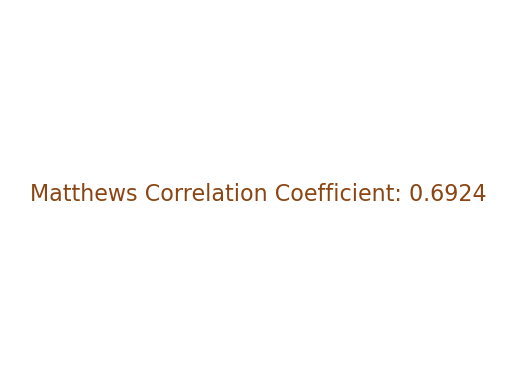

In [48]:
mcc = matthews_corrcoef(Y_test, final_pred)

# Create a plot and display the MCC value as text
plt.plot([])
plt.text(0,0, f'Matthews Correlation Coefficient: {mcc:.4f}', fontsize=16, ha='center', va='center',color="saddlebrown")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()


# Confusion Matrix

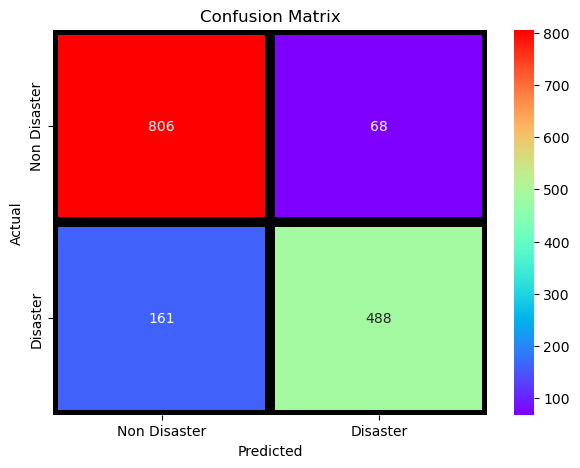

In [49]:
label_name = ["Non Disaster", "Disaster"]
plt.figure(figsize=(7, 5))
cm = confusion_matrix(Y_test, final_pred)
sns.heatmap(cm, annot=True, cmap="rainbow",fmt="d",lw=6,linecolor="black",xticklabels=label_name, yticklabels=label_name)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



# Classification Report

In [50]:
print(classification_report(Y_test,final_pred,target_names=label_name))

              precision    recall  f1-score   support

Non Disaster       0.83      0.92      0.88       874
    Disaster       0.88      0.75      0.81       649

    accuracy                           0.85      1523
   macro avg       0.86      0.84      0.84      1523
weighted avg       0.85      0.85      0.85      1523



# Test Data Analysis


In [51]:
df_test=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [52]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [53]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [54]:
df_test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [55]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [56]:
df_test.drop(["keyword","location"],axis=1,inplace=True)

In [57]:
df_test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [58]:
test_text=df_test["text"]

In [59]:
def xlnet_encode(final_text_data, max_len):
    input_ids = []
    attention_masks = []
    
    for i in range(len(final_text_data)):
        encode_data = xlnet_tokenizer.encode_plus(final_text_data[i], add_special_tokens=True, max_length=max_len, pad_to_max_length=True, return_attention_mask=True)
        input_ids.append(encode_data['input_ids'])
        attention_masks.append(encode_data["attention_mask"])
    
    return np.array(input_ids), np.array(attention_masks)

In [60]:
text_input_ids,text_attention_masks = xlnet_encode(test_text,max_len)

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [61]:
text_input_ids = np.array(text_input_ids)
text_attention_masks = np.array(text_attention_masks)
my_pred = model.predict([text_input_ids, text_attention_masks])
predicted_labels = np.where(my_pred >= 0.5, 1, 0) 
df_test['target'] = predicted_labels


102/102 [==============================] - 16s 161ms/step


In [62]:
df_test.head(10)

,id,text,target
0,0,Just happened a terrible car crash,1
1,2,"Heard about #earthquake is different cities, s...",1
2,3,"there is a forest fire at spot pond, geese are...",1
3,9,Apocalypse lighting. #Spokane #wildfires,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1
5,12,We're shaking...It's an earthquake,1
6,21,They'd probably still show more life than Arse...,0
7,22,Hey! How are you?,0
8,27,What a nice hat?,0
9,29,Fuck off!,0


In [63]:
df_test["target"].value_counts()

0    2060
1    1203
Name: target, dtype: int64

In [64]:
df0=df_test.copy()
df0.drop("text",axis=1,inplace=True)
df0.to_csv("my_submission.csv",index=False)